In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from scipy.interpolate import InterpolatedUnivariateSpline as spline
from scipy.special import gammainc

In [82]:
from src.hbtp.HBTReader import HBTReader
from src import read
from src import cosmology
from src import nfw
from src import einasto

matplotlib.rcParams['figure.figsize'] = (12.0, 12.0)

### Analysis parameters

In [10]:
snap = 122
nbins = 20
bin = 10

r = HBTReader("./data/")

### Subhalo mass function

In [11]:
ss = r.LoadSubhalos(snap)
ss = ss[(ss['HostHaloId'] != -1) & (ss['BoundM200Crit'] > 0.0)& (ss['Nbound'] >= 20)]

counts, bin_edges = np.histogram(np.log10(ss['Nbound']), 20)
ss = np.lib.recfunctions.append_fields(ss, 'bin',\
    np.digitize(np.log10(ss['BoundM200Crit']), bin_edges),\
    usemask=False)
bins = 0.5*(bin_edges[1:] + bin_edges[:-1])
print(counts, bin_edges, bins)

[28966 26091 21066 14867  9900  6122  3670  2285  1300   782   463   265
   172    75    49    31    11     8     3     4] [ 1.30103     1.55091011  1.80079023  2.05067035  2.30055047  2.55043059
  2.80031071  3.05019083  3.30007095  3.54995107  3.79983119  4.04971131
  4.29959143  4.54947155  4.79935167  5.04923178  5.2991119   5.54899202
  5.79887214  6.04875226  6.29863238] [ 1.42597006  1.67585017  1.92573029  2.17561041  2.42549053  2.67537065
  2.92525077  3.17513089  3.42501101  3.67489113  3.92477125  4.17465137
  4.42453149  4.67441161  4.92429173  5.17417184  5.42405196  5.67393208
  5.9238122   6.17369232]


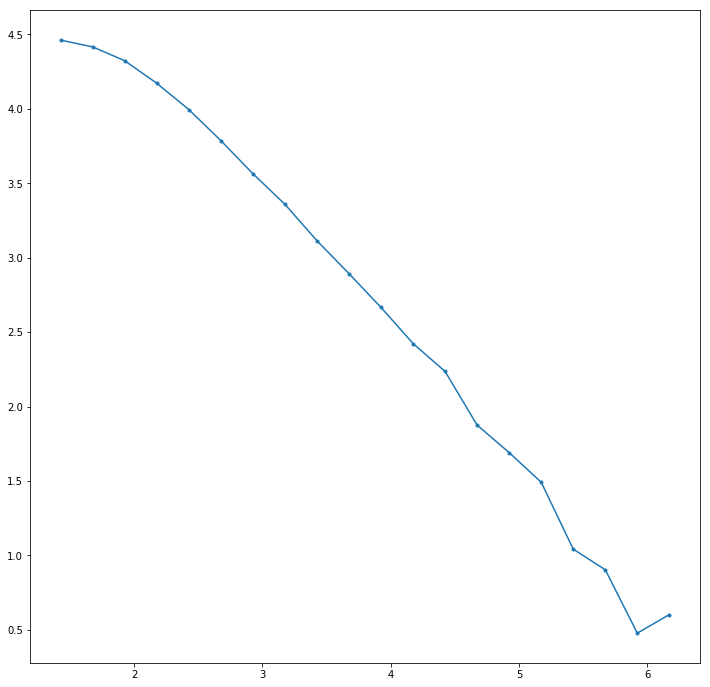

In [12]:
plt.plot(bins, np.log10(counts), color='C0', marker='.')

### Halo mass function

Create a histogram to contain all FoF haloes, and use the bins to digitize the `M200Crit` field.

In [13]:
hs = r.LoadHostHalos(snap)[['HaloId','R200CritComoving','M200Crit','CenterOffset']]
hs = hs[(hs['M200Crit'] >= 20) & (hs['CenterOffset'] >= 0.1)]
hs['M200Crit'] = 1e10*hs['M200Crit']

counts, bin_edges = np.histogram(np.log10(hs['M200Crit']), nbins)
hs = np.lib.recfunctions.append_fields(hs, 'bin',\
    np.digitize(np.log10(hs['M200Crit']), bin_edges),\
    usemask=False)
bins = 0.5*(bin_edges[1:] + bin_edges[:-1])
print(counts, bin_edges, bins)

[12779 16757 14368 10239  6547  3833  2200  1344   839   521   295   210
   116    63    40    24     9     6     5     3] [ 11.30992889  11.39537587  11.48082285  11.56626983  11.6517168
  11.73716378  11.82261076  11.90805774  11.99350471  12.07895169
  12.16439867  12.24984565  12.33529263  12.4207396   12.50618658
  12.59163356  12.67708054  12.76252751  12.84797449  12.93342147
  13.01886845] [ 11.35265238  11.43809936  11.52354634  11.60899332  11.69444029
  11.77988727  11.86533425  11.95078123  12.0362282   12.12167518
  12.20712216  12.29256914  12.37801611  12.46346309  12.54891007
  12.63435705  12.71980402  12.805251    12.89069798  12.97614496]


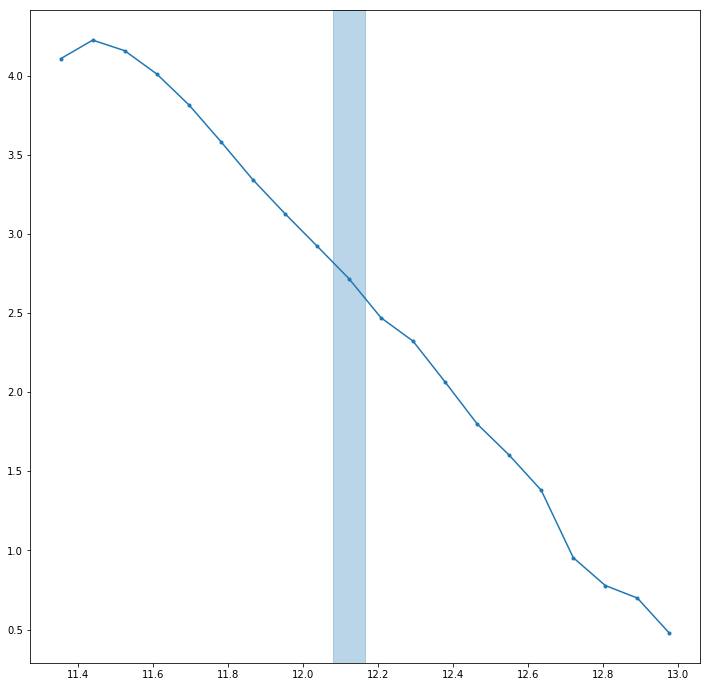

In [14]:
plt.plot(bins, np.log10(counts), color='C0', marker='.')
plt.axvspan(bin_edges[bin-1], bin_edges[bin], color='C0', alpha=0.3)

### Concentration - mass relation

In [15]:
hs = hs[hs['bin'] == bin]

### Density profile

In [127]:
np.s_[hs['HaloId']]

array([ 577,  651,  678,  697,  698,  703,  706,  707,  752,  762,  769,
        778,  808,  830,  832,  839,  842,  862,  866,  871,  873,  879,
        908,  914,  915,  917,  926,  929,  940,  945,  947,  953,  957,
        960,  964,  965,  966,  967,  971,  973,  975,  981,  982,  996,
       1001, 1010, 1014, 1021, 1025, 1026, 1030, 1035, 1036, 1042, 1045,
       1047, 1049, 1050, 1052, 1053, 1058, 1062, 1063, 1065, 1072, 1081,
       1082, 1083, 1084, 1087, 1088, 1092, 1094, 1095, 1101, 1103, 1105,
       1106, 1107, 1110, 1113, 1115, 1116, 1119, 1120, 1121, 1122, 1124,
       1126, 1127, 1129, 1131, 1132, 1133, 1134, 1137, 1139, 1142, 1143,
       1144, 1146, 1147, 1149, 1150, 1153, 1155, 1156, 1158, 1159, 1160,
       1161, 1163, 1164, 1165, 1167, 1168, 1170, 1173, 1174, 1176, 1177,
       1181, 1182, 1183, 1189, 1190, 1191, 1192, 1193, 1194, 1196, 1198,
       1199, 1201, 1202, 1203, 1206, 1208, 1210, 1212, 1213, 1217, 1218,
       1219, 1222, 1224, 1226, 1227, 1230, 1232, 12

/cosma/local/Python/3.6.0/lib/python3.6/site-packages/ipykernel_launcher.py:24: RuntimeWarning: divide by zero encountered in log10


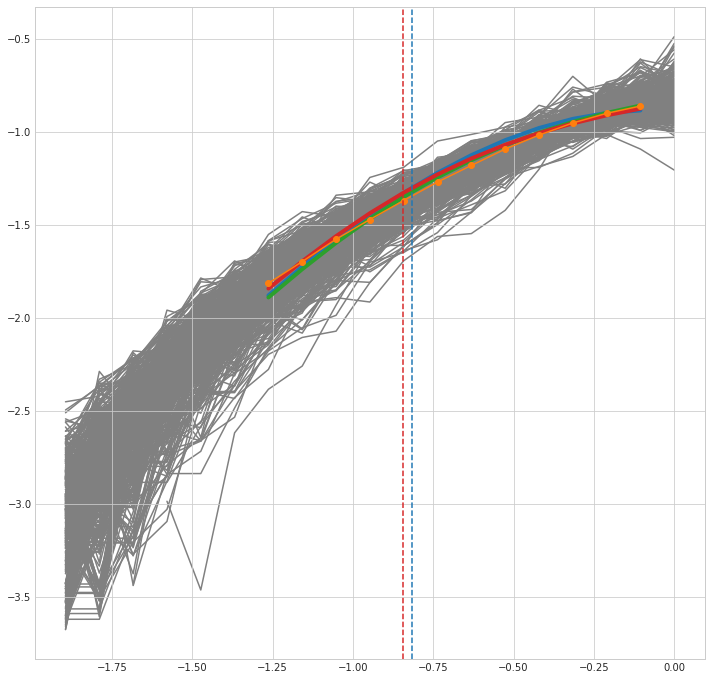

In [130]:
ps = r.GetHostProfile([list(hs['HaloId']),], snap)
xmin = 0.5*np.cbrt((4.0*np.pi)/(3.0*np.sum(np.mean(ps, axis=0))))
particles = np.sum(ps, axis=1)
ps = np.divide(ps.T, np.sum(ps, axis=1)).T
p = np.median(ps, axis=0)
x = np.linspace(-2.0, 0.0, 20)
vol = np.diff(np.power(np.append([0.0], np.power(10.0, x)), 3.0))

xmax = 0.8
idx = np.where((np.power(10,x) < xmax) & (np.power(10,x) > xmin))

c, a, chi2 = einasto.fit(p, lambda c, a: einasto.m(np.power(10.0, x), c, a),\
    np.linspace(1.0, 10.0, 100), np.linspace(0.01, 0.99, 100))
rho_s = np.log10(einasto.rho_enc(1.0/c, c, a))

c_nfw, chi2_nfw = nfw.fit(p, lambda c: nfw.m(np.power(10.0, x), c),\
    np.linspace(1.0, 10.0, 100))
rho_s_nfw = np.log10(nfw.rho_enc(1.0/c, c))

plt.plot(x[idx], np.log10(einasto.m(np.power(10.,x), c, a)[idx]),\
    color='C0', linewidth=4, zorder=1)

plt.plot(x[idx], np.log10(nfw.m(np.power(10.,x), c_nfw)[idx]),\
    color='C2', linewidth=4, zorder=2)

plt.plot(x[idx], np.log10(nfw.m(np.power(10.,x), 7.943282347242816)[idx]),\
    color='C3', linewidth=4, zorder=2)

[plt.plot(x[1:], np.log10(_[1:]), color='grey', zorder=0) for _ in ps]
plt.plot(x[idx], np.log10(p[idx]), color='C1', marker='o', zorder=2)
plt.axvline(np.log10(1.0/c), color='C0', linestyle='--')
plt.axvline(np.log10(1.0/c_nfw), color='C3', linestyle='--')

### Collapsed Mass History

In [24]:
F = einasto.m_enc(1.0/c, c, a)
print(F)

0.180492463225


In [25]:
ms = np.array(read.cmh(snap).loc[hs['HaloId']], dtype=np.float)
ms = np.divide(ms.T, ms[:,-1]).T
m = np.mean(ms, axis=0)

zs = read.snaps()
# np.genfromtxt('./output/hbtp/redshift_list.txt',\
#     dtype=np.dtype([('snapshot',np.int32), ('redshift',np.float32)]))
rho = cosmology.rho_c(\
    np.array([zs[zs['Snapshot'] == s][0]['Redshift']\
    for s in np.arange(1+snap-ms.shape[1], 1+snap)]))\
    / cosmology.rho_c(zs[zs['Snapshot'] == snap][0]['Redshift'])

In [26]:
m_f = F*m[-1]
y1, y2 = m[m > m_f][0], m[m < m_f][-1]
x1, x2 = rho[m > m_f][0], rho[m < m_f][-1]
rho_f = (np.log10(x1/x2)/np.log10(y1/y2))*(np.log10(m_f/y1))+np.log10(x1)

/cosma/local/Python/3.6.0/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log10
  """Entry point for launching an IPython kernel.
/cosma/local/Python/3.6.0/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log10
  


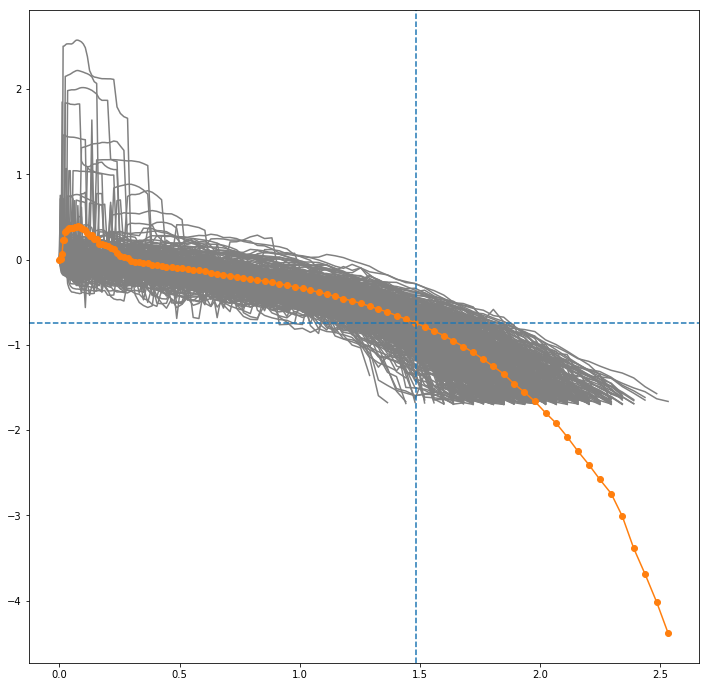

In [27]:
[plt.plot(np.log10(rho), np.log10(_), color='grey') for _ in ms]
plt.plot(np.log10(rho), np.log10(m),\
    color='C1', marker='o')
plt.axhline(np.log10(m_f), color='C0', linestyle='--')
plt.axvline(rho_f, color='C0', linestyle='--')

### Density - density relation

After the analysis above has been done for all mass bins, for all snapshots, we can start plotting the density - density relation.

In [28]:
rho_f, rho_s

(1.4833764440103265, 4.0043299933076497)

In [33]:
def plot(ax, ds):
    ax.plot([0.0, 3.0], np.log10(400.0 * np.power(10.0, np.array([0.0, 3.0]))), 'k-')

    markers = [['o', None], ['s', None], ['^', None], ['*', None], ['x', None]]
    colours = [['C0', None], ['C1', None]]

    for i,snap in enumerate(np.unique(ds['snap'])):
        for j,g in enumerate(np.unique(ds['g'])):
            for _, row in ds[(ds['snap'] == snap) & (ds['g'] == g)].iterrows():
                ax.scatter(
                    row['rho_f'], row['rho_s'],
                    color=colours[j][0],
                    marker=markers[i][0],
                    s=row['bin']*30,
                    alpha=0.6
                )
                markers[i][1] = plt.Line2D([], [], label='snap %d'%snap,
                    color='k', marker=markers[i][0], linestyle='')
            colours[j][1] = plt.Line2D([], [], label=g,
                color=colours[j][0], marker='o', linestyle='')

    ax.set_xlabel(r'$\log_{10}(\rho_{crit}(z_{form})/\rho_{crit}(z_0))$')
    ax.set_ylabel(r'$\log_{10}(\langle\rho_{s}\rangle/\rho_{crit}(z_0))$')
    ax.set_xlim((0.0, 2.0))
    ax.set_ylim((2.0, 5.0))

#     l1 = ax.legend(handles=[markers[i][1] for i in range(len(markers))], loc='upper left')
#     l2 = ax.legend(handles=[colours[j][1] for j in range(len(colours))], loc='lower right')
#     ax.add_artist(l1)

In [30]:
def read():
    ds = pd.DataFrame()

    for g in ['gr', 'fr']:
        for p in ['nfw', 'einasto']:
            _ = pd.read_csv('/gpfs/data/dc-oles1/merger_trees/output/%s/%s.csv' % (g, p))
            _['g'] = g
            ds = pd.concat([ds, _])

    ds = ds.reset_index()
    del ds['index']
    
    return ds

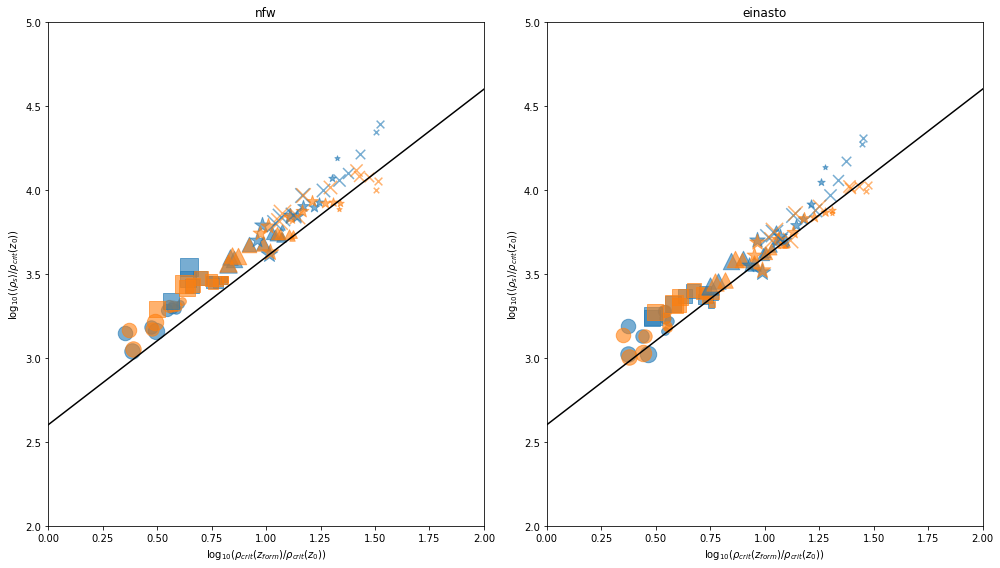

In [34]:
d = read()

fig, ax = plt.subplots(1, 2, figsize=(14, 8))

for i,p in enumerate(['nfw', 'einasto']):
    plot(ax[i], d[d['profile'] == p])
    ax[i].set_title(p)

fig.tight_layout()

- plot c-m for different bins, use theoretical values of c to plot NFW profiles (compare to fits)
    - x-y: r-M, values from different mass bins, as well as analytical curve (steeper?)
    - compare concentrations of profiles of different mass bins on the  same plot
- fit to individual profiles & average later
- Tuesday 1pm

In [102]:
import seaborn as sns

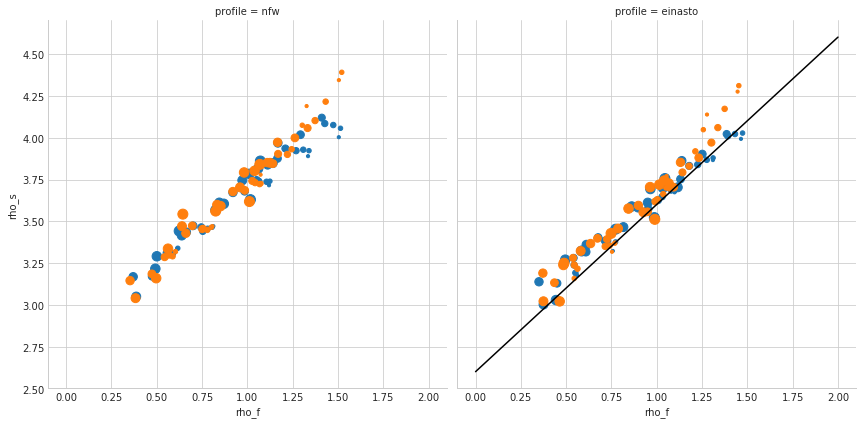

In [110]:
sns.FacetGrid(d, col='profile', hue='g', size=6)\
    .map(plt.scatter, 'rho_f', 'rho_s', s=d['bin']*10)
plt.plot([0.0, 2.0], np.log10(400.0 * np.power(10.0, np.array([0.0, 2.0]))), 'k-')